In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns


In [2]:
DATA_PATH = "../Data/processed/biomedical_preprocessed.csv"
df = pd.read_csv(DATA_PATH)

df = df[["a_x_filt", "a_y_filt", "a_z_filt", "subject_id", "activity"]]
df.head()


,a_x_filt,a_y_filt,a_z_filt,subject_id,activity
0,-0.121752,0.270153,-0.227040,s12,run
1,-0.145858,0.279853,-0.266853,s12,run
2,-0.170565,0.297933,-0.298288,s12,run
3,-0.192280,0.312419,-0.325533,s12,run
4,-0.221778,0.315530,-0.362357,s12,run


In [17]:

import tensorflow as tf

print(tf.__version__)  # Should be 2.13.0

2.13.0


In [3]:
df.dropna(inplace=True)
print("Dataset shape:", df.shape)


Dataset shape: (1458152, 5)


In [4]:
#creating windows
WINDOW_SIZE = 128
STEP_SIZE = 64

def create_windows(df):
    X, y, subjects = [], [], []

    for subject in df["subject_id"].unique():
        subject_df = df[df["subject_id"] == subject]

        for activity in subject_df["activity"].unique():
            activity_df = subject_df[subject_df["activity"] == activity]

            data = activity_df[["a_x_filt", "a_y_filt", "a_z_filt"]].values

            for i in range(0, len(data) - WINDOW_SIZE, STEP_SIZE):
                window = data[i:i + WINDOW_SIZE]
                X.append(window)
                y.append(activity)
                subjects.append(subject)

    return np.array(X), np.array(y), np.array(subjects)


In [5]:
X, y, subjects = create_windows(df)

print("X shape:", X.shape)   # (samples, time, channels)
print("y shape:", y.shape)


X shape: (22776, 128, 3)
y shape: (22776,)


In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Activities:", le.classes_)


Activities: ['run' 'sit' 'walk']


In [7]:
#train test split subject wise
unique_subjects = np.unique(subjects)
split = int(0.7 * len(unique_subjects))

train_subjects = unique_subjects[:split]
test_subjects  = unique_subjects[split:]

train_idx = np.isin(subjects, train_subjects)
test_idx  = np.isin(subjects, test_subjects)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

print("Train windows:", X_train.shape)
print("Test windows:", X_test.shape)


Train windows: (11374, 128, 3)
Test windows: (11402, 128, 3)


In [8]:
#CNN MODEL
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(WINDOW_SIZE, 3)),
    MaxPooling1D(2),

    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 64)           1024      
                                                                 
 max_pooling1d (MaxPooling1  (None, 62, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 58, 128)           41088     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 29, 128)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 3712)              0         
                                                                 
 dense (Dense)               (None, 128)               4

In [9]:
#TRAIN CNN
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    callbacks=[early_stop],
    shuffle=True
)


Epoch 1/20
569/569 [==============================] - 11s 17ms/step - loss: 0.2342 - accuracy: 0.9098 - val_loss: 0.7883 - val_accuracy: 0.6558
Epoch 2/20
569/569 [==============================] - 12s 21ms/step - loss: 0.1558 - accuracy: 0.9413 - val_loss: 0.5947 - val_accuracy: 0.7640
Epoch 3/20
569/569 [==============================] - 10s 17ms/step - loss: 0.1408 - accuracy: 0.9487 - val_loss: 0.2443 - val_accuracy: 0.9029
Epoch 4/20
569/569 [==============================] - 11s 19ms/step - loss: 0.1218 - accuracy: 0.9550 - val_loss: 0.3233 - val_accuracy: 0.8690
Epoch 5/20
569/569 [==============================] - 11s 19ms/step - loss: 0.1134 - accuracy: 0.9613 - val_loss: 0.5042 - val_accuracy: 0.8145
Epoch 6/20
569/569 [==============================] - 11s 20ms/step - loss: 0.1109 - accuracy: 0.9620 - val_loss: 0.3006 - val_accuracy: 0.8708
Epoch 7/20
569/569 [==============================] - 12s 20ms/step - loss: 0.0958 - accuracy: 0.9643 - val_loss: 0.3857 - val_accuracy:

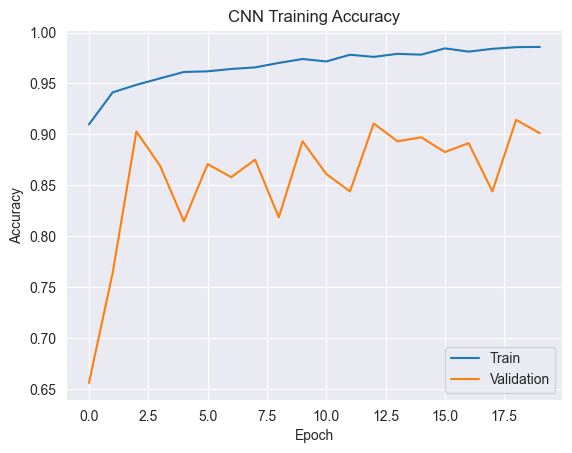

In [10]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Training Accuracy")
plt.legend()
plt.show()


In [11]:
#EVALUATION
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=1)


Test Accuracy: 77.35%
357/357 [==============================] - 2s 5ms/step


              precision    recall  f1-score   support

         run       0.66      0.68      0.67      3822
         sit       1.00      1.00      1.00      3790
        walk       0.66      0.64      0.65      3790

    accuracy                           0.77     11402
   macro avg       0.77      0.77      0.77     11402
weighted avg       0.77      0.77      0.77     11402



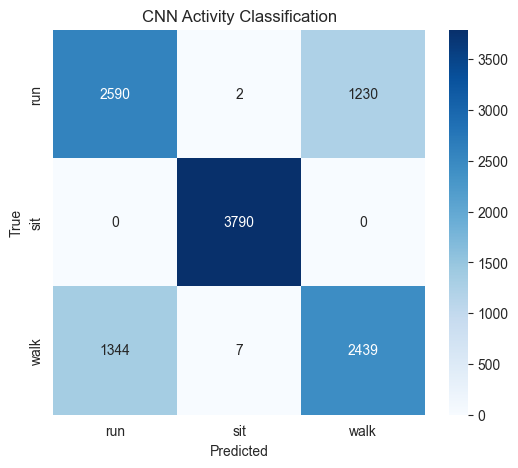

In [14]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Activity Classification")
plt.show()


In [16]:
# ================================
# Save Activity CNN Model (No Scaler)
# ================================

import os
import joblib
from tensorflow.keras.models import save_model  # ensure using tf.keras

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the CNN model in TensorFlow Keras format
model.save("models/activity_cnn_model.keras", save_format="keras")  # ✅ CPU version compatible

# Save the LabelEncoder using joblib
joblib.dump(le, "models/activity_label_encoder.pkl")

print("✅ Activity CNN model and LabelEncoder saved successfully")



✅ Activity CNN model and LabelEncoder saved successfully
